# Vinther et al. (2011)--Minimal Model of the HPA Axis

# Table of Contents
1. [Imports](#imports)
2. [Parameters and Initial Conditions](#params)
3. [Put Raw Data into Arrays](#rawdata)
    1. [Plot Data Sets](#plotdata)
4. [Model Function--Includes ODE Solver](#modelfunction)
5. [Cost Function Definition](#cost)
6. [Run the Optimization](#run)
7. [Save Output to File](#saveoutput)
8. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
9. [Plots](#plots)
10. [No Optimization Run and Plot](#no-opt)
11. [Dependencies](#dependencies)

## Imports <a name="imports"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import pandas as pd
from HPAmodeling import ODEsolver
from HPAmodeling import costFun
from HPAmodeling import dataImport

# Parameters and Initial Conditions <a name="params"></a>

In [3]:
# initial conditions
# order: CRH, ACTH, CORT

# based on: golierPTSD
y0 = [10, 44.22111, 10.68792]

In [5]:
# authors' listed parameter values
k0 = 1.7696
k1 = 0.12734
k2 = 0.0013198
w1 = 0.17329
w2 = 0.034832
w3 = 0.0090726
rho = 0.5
mu = 0.5
alpha = 3
c = 3.055

# save these parameter values in an array to use when running without optimization
authors_params = [k0, k1, k2, w1, w2, w3, rho, mu, alpha, c]

In [6]:
# time delay parameter, for recreation of Fig 5
tau = 19

In [149]:
# compute bounds based on +- 10%
bound = .191
print(bound - bound*.1)
print(bound + bound*.1)

0.1719
0.2101


In [150]:
# bounds for parameter optimization
# starting with +- 10% since we do not have published ranges in the paper (except for w2, w3, rho, mu and alhpa)
bounds = [(1.59264, 1.94656), (0.11460600000000001, 0.140074), (0.00118782, 0.0014517800000000002), (0.155961, 0.190619), (0.028761293799167857, 0.04414950194649333), (0.007517865298914807, 0.011591089975918819), (0, 1), (0, 1), (1, 5), (2.7495000000000003, 3.3605)]

bounds_delay = [(1.59264, 2.91973), (0.11460600000000001, 0.2101), (0.00118782, 0.0014517800000000002), (0.155961, 0.190619), (0.028761293799167857, 0.04414950194649333), (0.007517865298914807, 0.011591089975918819), (0, 1), (0, 1), (1, 5), (2.7495000000000003, 3.3605)]


In [59]:
# time interval definiton for integration
# starting with 1440 minutes, since we will be doing basal data sets and the time scale is minutes for this model
t_start = -0.1
t_end = 1440.1
t_step = 0.1

## Put Raw Data into Arrays <a name="rawdata"></a>

In [31]:
yehudaControlCortisol, yehudaControlCortisol_smooth, yehudaPTSDCortisol, yehudaPTSDCortisol_smooth, yehudaDepressedCortisol, yehudaDepressedCortisol_smooth = dataImport.yehuda()

In [32]:
carrollControlCortisol, carrollControlCortisol_rearr, carrollControlCortisol_smooth, carrollControlCortisol_rearr_smooth, carrollControlACTH, carrollControlACTH_rearr, carrollControlACTH_smooth, carrollControlACTH_rearr_smooth, carrollHCDepressedCortisol, carrollHCDepressedCortisol_rearr, carrollHCDepressedCortisol_smooth, carrollHCDepressedCortisol_rearr_smooth, carrollHCDepressedACTH, carrollHCDepressedACTH_rearr, carrollHCDepressedACTH_smooth, carrollHCDepressedACTH_rearr_smooth, carrollLCDepressedCortisol, carrollLCDepressedCortisol_rearr, carrollLCDepressedCortisol_smooth, carrollLCDepressedCortisol_rearr_smooth, carrollLCDepressedACTH, carrollLCDepressedACTH_rearr, carrollLCDepressedACTH_smooth, carrollLCDepressedACTH_rearr_smooth = dataImport.carroll()

In [33]:
golierPTSDCortisol, golierPTSDCortisol_rearr, golierPTSDCortisol_smooth, golierPTSDCortisol_rearr_smooth, golierPTSDACTH, golierPTSDACTH_rearr, golierPTSDACTH_smooth, golierPTSDACTH_rearr_smooth, golierNonPTSDTraumaExposedCortisol, golierNonPTSDTraumaExposedCortisol_rearr, golierNonPTSDTraumaExposedCortisol_smooth, golierNonPTSDTraumaExposedCortisol_rearr_smooth, golierNonPTSDTraumaExposedACTH, golierNonPTSDTraumaExposedACTH_rearr, golierNonPTSDTraumaExposedACTH_smooth, golierNonPTSDTraumaExposedACTH_rearr_smooth, golierNonPTSDNonExposedCortisol, golierNonPTSDNonExposedCortisol_rearr, golierNonPTSDNonExposedCortisol_smooth, golierNonPTSDNonExposedCortisol_rearr_smooth, golierNonPTSDNonExposedACTH, golierNonPTSDNonExposedACTH_rearr, golierNonPTSDNonExposedACTH_smooth, golierNonPTSDNonExposedACTH_rearr_smooth = dataImport.golier()

In [34]:
bremnerAbusedPTSDCortisol, bremnerAbusedPTSDCortisol_rearr, bremnerAbusedPTSDCortisol_smooth, bremnerAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedPTSDCortisol, bremnerNonAbusedPTSDCortisol_rearr, bremnerNonAbusedPTSDCortisol_smooth, bremnerNonAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedNonPTSDCortisol, bremnerNonAbusedNonPTSDCortisol_rearr, bremnerNonAbusedNonPTSDCortisol_smooth, bremnerNonAbusedNonPTSDCortisol_rearr_smooth = dataImport.bremner()

In [36]:
nelsonCortisol, nelsonACTH, nelsonAtypicalCortisol, nelsonAtypicalACTH, nelsonMelancholicCortisol, nelsonMelancholicACTH, nelsonNeitherCortisol, nelsonNeitherACTH, nelsonHealthyCortisol, nelsonHealthyACTH, atypical_ids, melancholic_ids, neither_ids, healthy_ids = dataImport.nelson()

### Plot Data Sets <a name="plotdata"></a>

In [37]:
for i in range(len(golierPTSDCortisol)):
    golierPTSDCortisol[i,0] = golierPTSDCortisol[i,0]*60
    golierNonPTSDTraumaExposedCortisol[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]*60
    golierNonPTSDNonExposedCortisol[i,0] = golierNonPTSDNonExposedCortisol[i,0]*60
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol_rearr[i,0]*60
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol_rearr[i,0]*60
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol_rearr[i,0]*60
    golierPTSDCortisol_smooth[i,0] = golierPTSDCortisol_smooth[i,0]*60
    golierNonPTSDTraumaExposedCortisol_smooth[i,0] = golierNonPTSDTraumaExposedCortisol_smooth[i,0]*60
    golierNonPTSDNonExposedCortisol_smooth[i,0] = golierNonPTSDNonExposedCortisol_smooth[i,0]*60
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol_rearr_smooth[i,0]*60
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0]*60
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol_rearr_smooth[i,0]*60
    
for i in range(len(golierPTSDACTH)):
    golierPTSDACTH[i,0] = golierPTSDACTH[i,0]*60
    golierNonPTSDTraumaExposedACTH[i,0] = golierNonPTSDTraumaExposedACTH[i,0]*60
    golierNonPTSDNonExposedACTH[i,0] = golierNonPTSDNonExposedACTH[i,0]*60
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH_rearr[i,0]*60
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH_rearr[i,0]*60
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH_rearr[i,0]*60
    golierPTSDACTH_smooth[i,0] = golierPTSDACTH_smooth[i,0]*60
    golierNonPTSDTraumaExposedACTH_smooth[i,0] = golierNonPTSDTraumaExposedACTH_smooth[i,0]*60
    golierNonPTSDNonExposedACTH_smooth[i,0] = golierNonPTSDNonExposedACTH_smooth[i,0]*60
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH_rearr_smooth[i,0]*60
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0]*60
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH_rearr_smooth[i,0]*60

In [38]:
for i in range(len(bremnerAbusedPTSDCortisol)):
    bremnerAbusedPTSDCortisol[i,0] = bremnerAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedPTSDCortisol[i,0] = bremnerNonAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedNonPTSDCortisol[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]*60
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol_rearr[i,0]*60
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol_rearr[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol_rearr[i,0]*60
    bremnerAbusedPTSDCortisol_smooth[i,0] = bremnerAbusedPTSDCortisol_smooth[i,0]*60
    bremnerNonAbusedPTSDCortisol_smooth[i,0] = bremnerNonAbusedPTSDCortisol_smooth[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol_smooth[i,0]*60
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol_rearr_smooth[i,0]*60
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0]*60

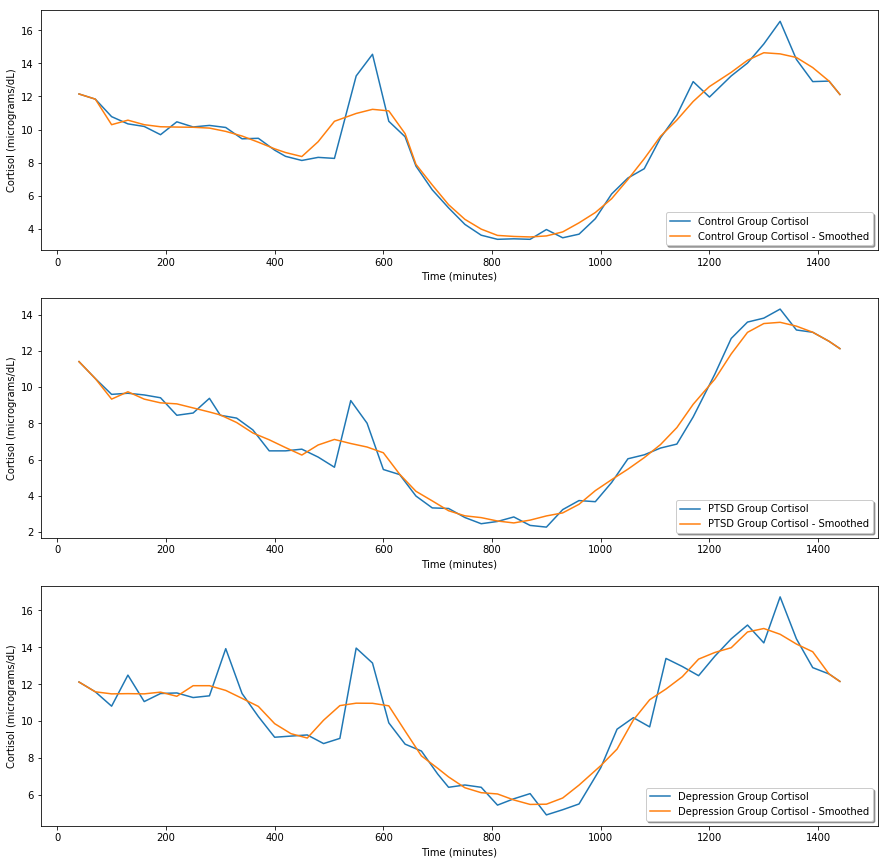

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


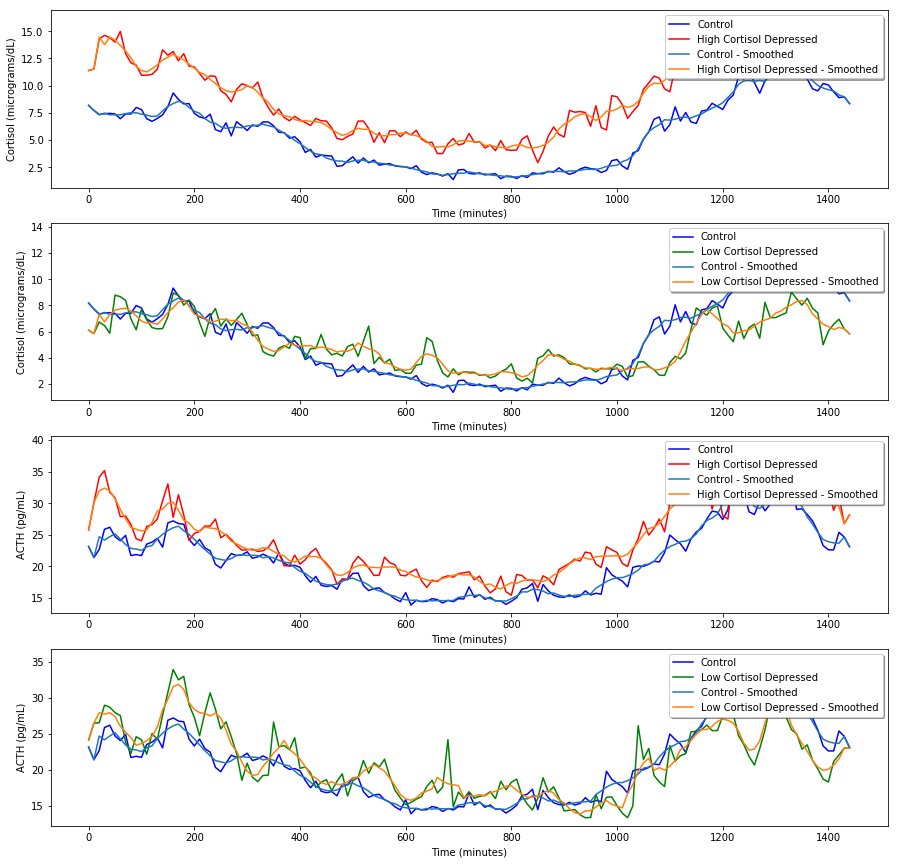

In [40]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

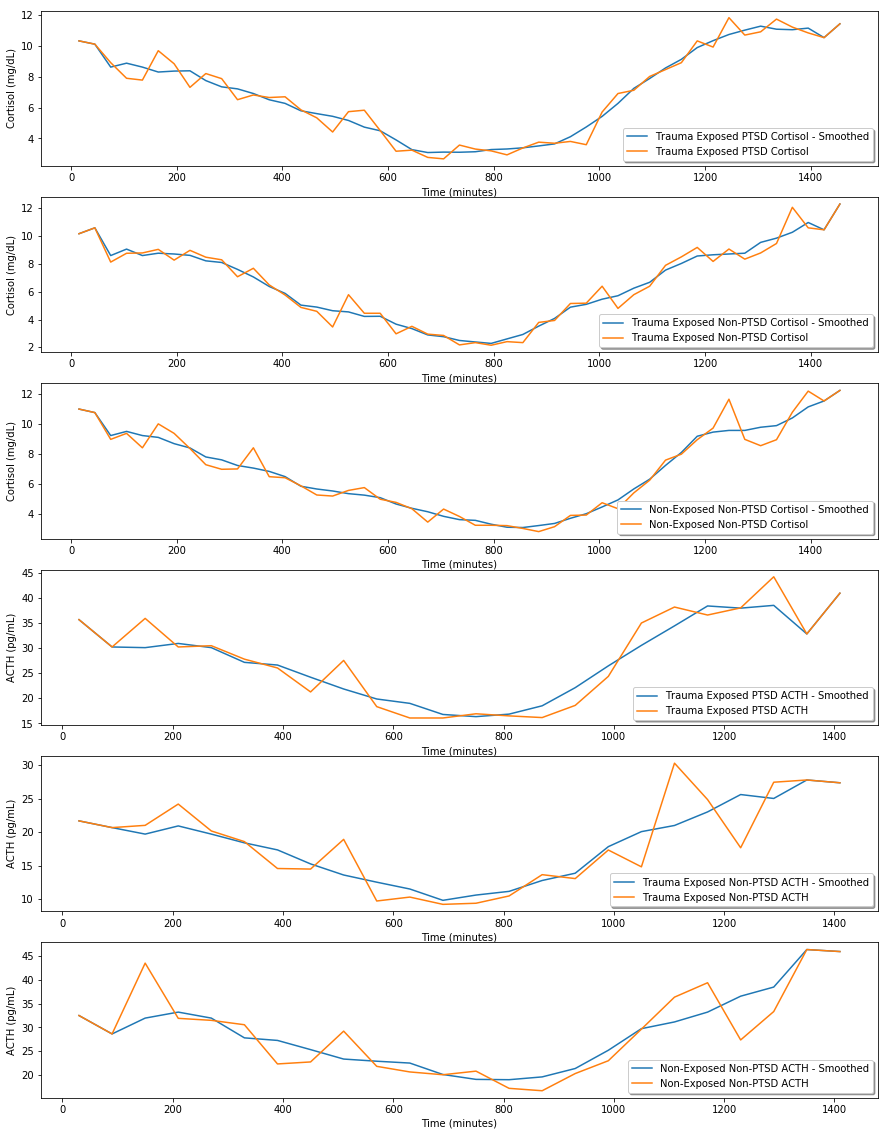

In [41]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


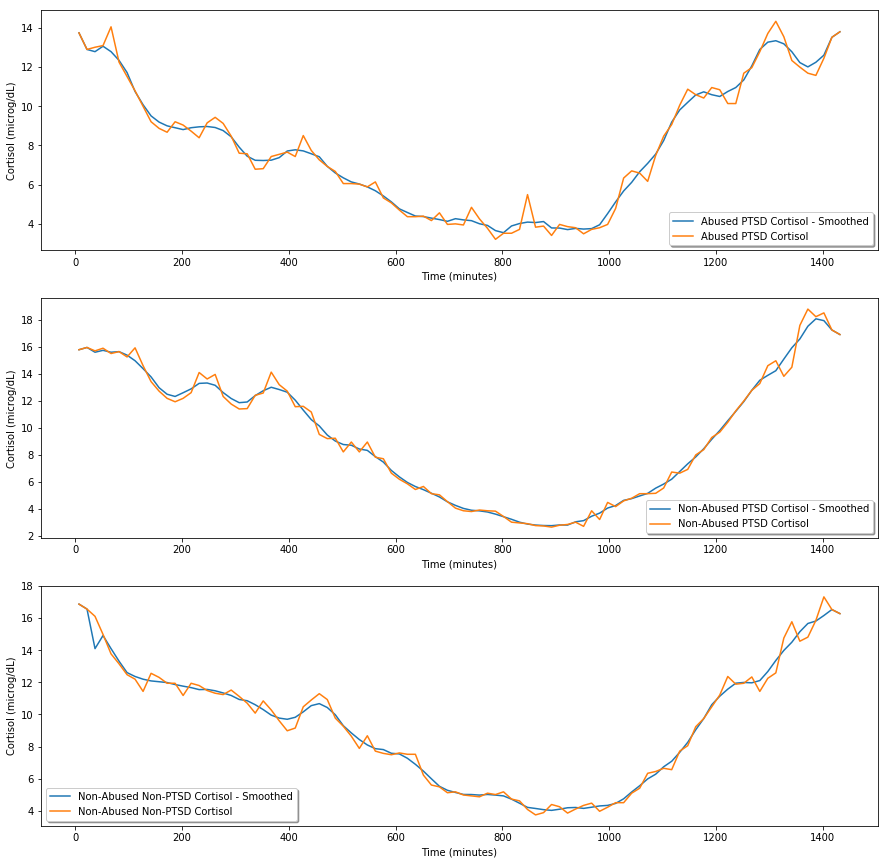

In [42]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


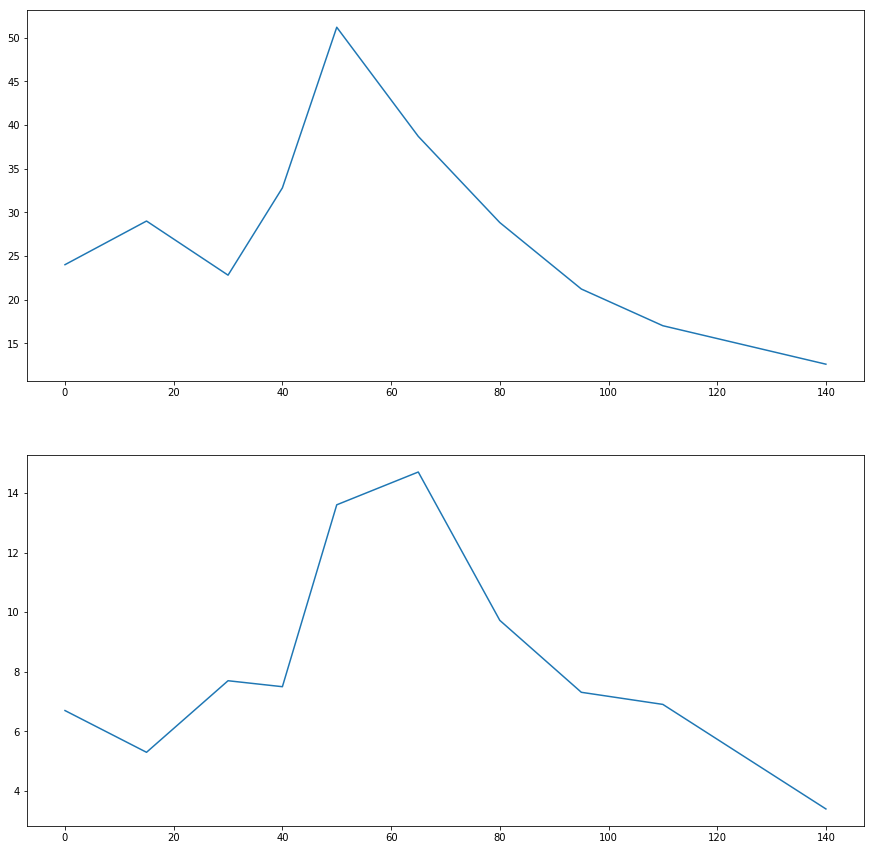

In [43]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3])

## Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [151]:
def model(params, ics):
    def ode_system(t, y):
        dy = np.zeros(3) # 3 equation system, R = CRH, A = ACTH, C = CORT
        
        [k0, k1, k2, w1, w2, w3, rho, mu, alpha, c] = params
        
        # ordinary differential equation definitions
        #dy[0] = k0*(1 - mu*(y[2]**alpha)/(y[2]**alpha + c**alpha)) - w1*y[0]
        #dy[1] = k1*(1 - rho*(y[2]**alpha)/(y[2]**alpha + c**alpha))*y[0] - w2*y[1]
        #dy[2] = k2*y[1] - w3*y[2]
        
        # delay differential equation definitions
        dy[0] = k0*(1 - mu*(ODEsolver.delayedCORT**alpha)/(ODEsolver.delayedCORT**alpha + c**alpha)) - w1*y[0]
        dy[1] = k1*(1 - rho*(ODEsolver.delayedCORT**alpha)/(ODEsolver.delayedCORT**alpha + c**alpha))*y[0] - w2*y[1]
        dy[2] = k2*ODEsolver.delayedACTH - w3*y[2]
        
        return dy
    
    # Call the solve() function from my ODEsolver module, and pass all of the information it needs.
    # Arguments are as follows: ODE function to solve, array of initial conditions, start time, step size, end time
    # The last three arguments are optional (leave blank for ODE systems) for delay differential equation systems, 
    #  tau0 is the delay in CRH, tau1 is the delay in ACTH, tau2 is the delay in CORT, 
    #  and delay is an array of booleans to set whether we use delays in [CRH, ACTH, CORT]
    timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end, ode_steps = 1000, ode_atol = 1e-6, ode_rtol = 1e-6, tau1 = 19, tau2 = 19, delay = [False, True, True], delay_rough = True)
    
    # run without delays
    #timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end)
    
    return timeSeries

## Cost Function Definition <a name="cost"></a>

In [91]:
def cost_fun(params):
    simData = model(params, y0)
    
    return costFun.cost(params, carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], simData)

## Run the Optimization <a name="run"></a>

In [92]:
print(carrollControlACTH_rearr[0,1], carrollControlCortisol_rearr[0,1])

23.15829 8.18429


In [152]:
# initial conditions
# order: CRH, ACTH, CORT

# based on: carrollControl_rearr
y0 = [7.5, carrollControlACTH_rearr[0,1], carrollControlCortisol_rearr[0,1]]

In [160]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((144003, n))
sims_acth = np.zeros((144003, n))
sims_crh = np.zeros((144003, n))

In [ ]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds_delay, maxiter = 999, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0)
    # save CRH, cortisol and ACTH       
    # data into sims arrays
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 30.9463
differential_evolution step 2: f(x)= 30.9463
differential_evolution step 3: f(x)= 30.9463
differential_evolution step 4: f(x)= 30.9463
differential_evolution step 5: f(x)= 30.9463
differential_evolution step 6: f(x)= 30.9463
differential_evolution step 7: f(x)= 30.9463
differential_evolution step 8: f(x)= 30.9463


## Save Output to File <a name="saveoutput"></a>

In [ ]:
df_t = pd.DataFrame(optimizedSimData[:,0])
df_cort = pd.DataFrame(sims_cort)
df_acth = pd.DataFrame(sims_acth)
df_crh = pd.DataFrame(sims_crh)

df_t.to_excel(excel_writer = 'vintherModel_output/vintherModel-carroll-control-rearr-timeSteps-5-iterations-normalizedCost-delay19.xlsx')
df_cort.to_excel(excel_writer = 'vintherModel_output/vintherModel-carroll-control-rearr-sims-cort-5-iterations-normalizedCost-delay19.xlsx')
df_acth.to_excel(excel_writer = 'vintherModel_output/vintherModel-carroll-control-rearr-sims-acth-5-iterations-normalizedCost-delay19.xlsx')
df_crh.to_excel(excel_writer = 'vintherModel_output/vintherModel-carroll-control-rearr-sims-crh-5-iterations-normalizedCost-delay19.xlsx')

In [ ]:
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-opt-pars-5-iterations-delay19.txt', opt_pars)
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-sims-crh-5-iterations-delay19.txt', sims_crh)
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-sims-acth-5-iterations-delay19.txt', sims_acth)
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-sims-cort-5-iterations-delay19.txt', sims_cort)
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-initial-conditions-5-iterations-delay19.txt', y0)
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-bounds-5-iterations-delay19.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [ ]:
# compute parameter means and standard deviations
k0_mean = np.mean(opt_pars[:,1])
k0_std = np.std(opt_pars[:,1])
k1_mean = np.mean(opt_pars[:,2])
k1_std = np.std(opt_pars[:,2])
k2_mean = np.mean(opt_pars[:,3])
k2_std = np.std(opt_pars[:,3])
w1_mean = np.mean(opt_pars[:,4])
w1_std = np.std(opt_pars[:,4])
w2_mean = np.mean(opt_pars[:,5])
w2_std = np.std(opt_pars[:,5])
w3_mean = np.mean(opt_pars[:,6])
w3_std = np.std(opt_pars[:,6])
rho_mean = np.mean(opt_pars[:,7])
rho_std = np.std(opt_pars[:,7])
mu_mean = np.mean(opt_pars[:,8])
mu_std = np.std(opt_pars[:,8])
alpha_mean = np.mean(opt_pars[:,9])
alpha_std = np.std(opt_pars[:,9])
c_mean = np.mean(opt_pars[:,10])
c_std = np.std(opt_pars[:,10])

In [ ]:
# print a table of parameter means and standard deviations
print(tabulate([["k0", "%f +- %f" % (k0_mean, k0_std)], ["k1", "%f +- %f" % (k1_mean, k1_std)], ["k2", "%f +- %f" % (k2_mean, k2_std)], ["w1", "%f +- %f" % (w1_mean, w1_std)], ["w2", "%f +- %f" % (w2_mean, w2_std)], ["w3", "%f +- %f" % (w3_mean, w3_std)], ["rho", "%f +- %f" % (rho_mean, rho_std)], ["mu", "%f +- %f" % (mu_mean, mu_std)], ["alpha", "%f +- %f" % (alpha_mean, alpha_std)], ["c", "%f +- %f" % (c_mean, c_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))

In [ ]:
# save parameter means and std devs to a file
np.savetxt('vintherModel_output/vintherModel-carroll-control-rearr-param-means-stds-5-iterations-delay19.txt', [k0_mean, k0_std, k1_mean, k1_std, k2_mean, k2_std, w1_mean, w1_std, w2_mean, w2_std, w3_mean, w3_std, rho_mean, rho_std, mu_mean, mu_std, alpha_mean, alpha_std, c_mean, c_std])

## Create Plots <a name="plots"></a>

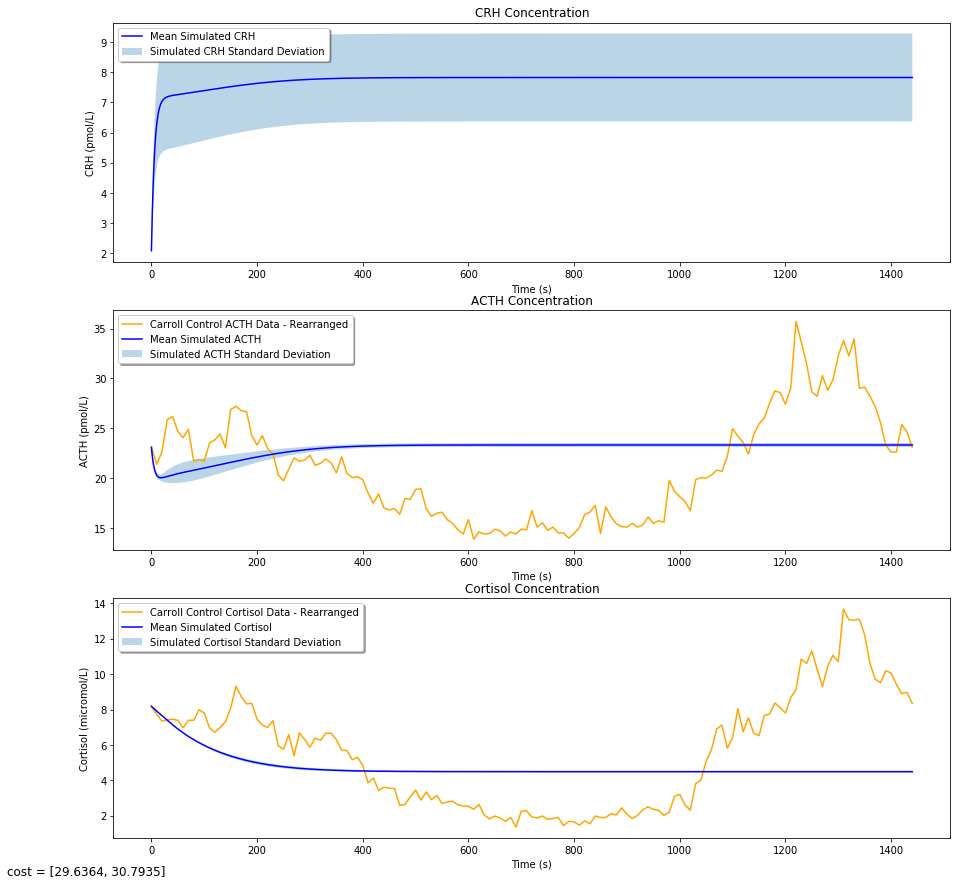

In [122]:
%matplotlib inline

# plot with 3 subfigures--one for CRH, one for ACTH and one for cortisol
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15, 15))

# if running more than one iteration of optimization, uncomment plot command with np.mean and fill_between
# and comment plot command without np.mean
#
# if only one run is stored in sims variables, comment out plot commands with np.mean and fill_between
#ax1.plot(optimizedSimData[:,0], sims_crh, label = "Simulated CRH Data", color = "blue")
ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Mean Simulated CRH", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (s)", ylabel = "CRH (pmol/L)", title = "CRH Concentration")

ax2.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], label = "Carroll Control ACTH Data - Rearranged", color = "orange")
#ax2.plot(optimizedSimData[:,0], sims_acth, label = "Simulated ACTH Data", color = "blue")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Mean Simulated ACTH", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (s)", ylabel = "ACTH (pmol/L)", title = "ACTH Concentration")

ax3.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], label = "Carroll Control Cortisol Data - Rearranged", color = "orange")
#ax3.plot(optimizedSimData[:,0], sims_cort, label = "Simulated Cortisol Data", color = "blue")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Mean Simulated Cortisol", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (s)", ylabel = "Cortisol (micromol/L)", title = "Cortisol Concentration")

# include the value of the cost function for this set of graphs at the bottom of the figure
txt = "cost = []"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 12)
plt.savefig("vintherModel_output/vintherModel-carroll-control-rearr-5-iterations-delay19.png", dpi = 300)


## No Optimization Run and Plot <a name="no-opt"></a>

In [133]:
# time interval for iteration
t_start = -0.01
t_end = 1440.01
t_step = 0.01

# set the initial conditions, based on Fig 5 in the paper
y0 = [9.5, 20, 2.5]

In [137]:
authors_params_delay = [2.6543, 0.191, 0.0013, 0.17329, 0.034832, 0.0090726, 1, 1, 5, 3.055]

In [146]:
%%time

# run the solver with authors' published parameters
optimizedSimData = model(authors_params, y0)
    
# save CRH, cortisol and ACTH data into sims arrays
sims_cort = optimizedSimData[:,3]
sims_acth = optimizedSimData[:,2]
sims_crh = optimizedSimData[:,1]

CPU times: user 829 ms, sys: 45.4 ms, total: 875 ms
Wall time: 888 ms


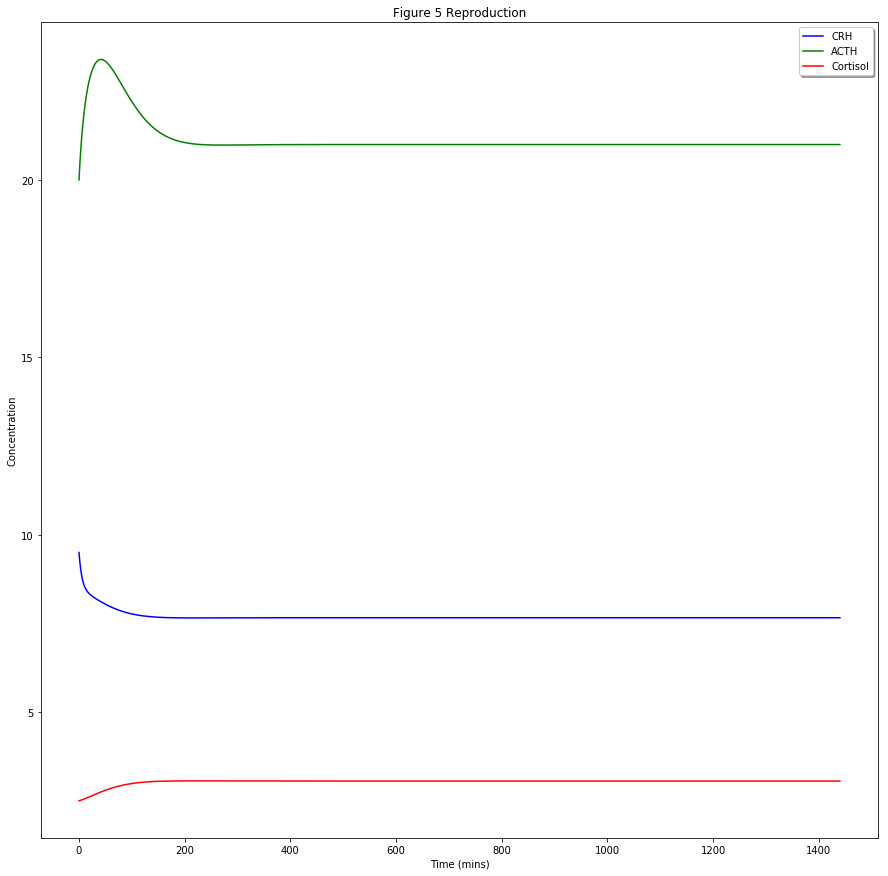

In [147]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows = 1, figsize = (15,15))

ax1.plot(optimizedSimData[:,0], sims_crh, color='blue', label = "CRH", )
ax1.plot(optimizedSimData[:,0], sims_acth, color='green', label = "ACTH")
ax1.plot(optimizedSimData[:,0], sims_cort, color='red', label = "Cortisol")
ax1.set(ylabel = "Concentration", xlabel = "Time (mins)", title = "Figure 5 Reproduction")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)

plt.savefig("vintherModel_output/vintherModel-figure5-reproduction-nodelay.png", dpi=300)

In [136]:
print(sims_crh[-1], sims_acth[-1], sims_cort[-1])

7.658944857587024 21.00016521024932 3.054914582863502


## Dependencies <a name="dependencies"></a>

In [56]:
%load_ext watermark

In [57]:
%watermark --iversions

numpy     : 1.21.5
mpld3     : 0.3.1.dev1
pandas    : 0.23.4
matplotlib: 3.0.1
scipy     : 1.1.0

